In [16]:
%matplotlib inline
# color and word detection
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import spatial
import cv2
import pytesseract
from itertools import chain, combinations

# clue generator
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from itertools import zip_longest
from IPython.display import HTML
import nltk
from nltk.stem import PorterStemmer
from nltk.data import find
nltk.download('word2vec_sample')

# in case we run into download issues
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

[nltk_data] Downloading package word2vec_sample to
[nltk_data]     /Users/harrisonchin1/nltk_data...
[nltk_data]   Package word2vec_sample is already up-to-date!


# Color Card Processing

In [17]:
# color card images
color_card = cv2.imread('assets/color_card.jpg')
cropped_color_card = color_card[300:1400, 275:1400]

### 1. Preprocessing Image

In [18]:
# this block is used to try and remove brightness/lighting problems
def preprocess_img(img):
  # Convert the image to LAB color space
  lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

  # Split the LAB image into its 3 channels
  l, a, b = cv2.split(lab)

  # Apply CLAHE to the L channel
  clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
  cl = clahe.apply(l)

  # increase brightnes of iamge
  limg = cv2.merge((cl,a,b))

  # Convert the image back to BGR color space
  processed_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

  return processed_img 

processed_color_card = preprocess_img(cropped_color_card)

In [19]:
# remove noise from the image
kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])

gray_orig = cv2.cvtColor(processed_color_card.copy(), cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray_orig,(5,5),0)
blur = cv2.filter2D(blur, -1, kernel)

In [20]:
# approx color ranges
lower_blue = np.array([60,100,50])
upper_blue = np.array([140,255,255])

lower_red = np.array([0,50,50])
upper_red = np.array([60,255,255])

lower_beige = np.array([0, 10, 120])
upper_beige = np.array([40, 80, 255])

# lower_black = np.array([0, 0, 0])
# upper_black = np.array([179, 255, 30])

# convert images to HSV standard
red_img = cv2.cvtColor(processed_color_card.copy(), cv2.COLOR_BGR2HSV)
blue_img = cv2.cvtColor(processed_color_card.copy(), cv2.COLOR_BGR2HSV)
beige_img = cv2.cvtColor(processed_color_card.copy(), cv2.COLOR_BGR2HSV)

# find each individual color using color masks
red_mask = cv2.inRange(red_img, lower_red, upper_red)
blue_mask = cv2.inRange(blue_img, lower_blue, upper_blue)
beige_mask = cv2.inRange(beige_img, lower_beige, upper_beige)

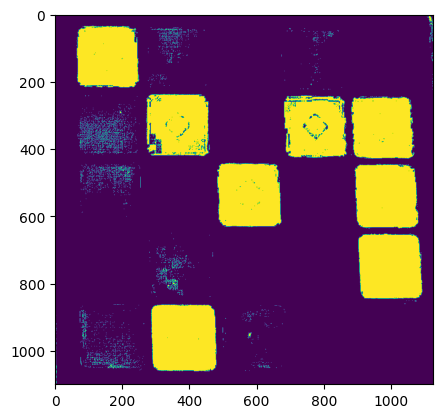

In [21]:
# test finding of red squares
plt.imshow(red_mask)

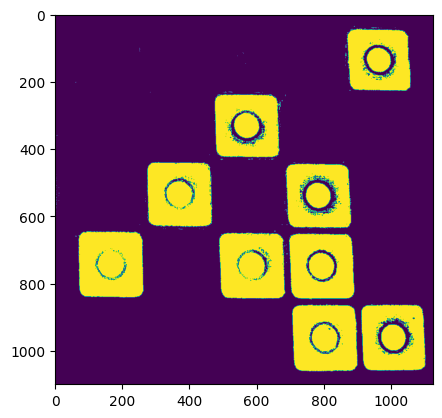

In [22]:
# test finding of blue squares
plt.imshow(blue_mask)

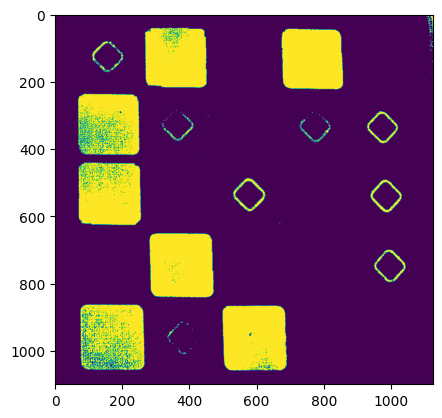

In [23]:
# test finding of beige squares
plt.imshow(beige_mask)

### 2. Contour Detection --> Detect Each Color Square

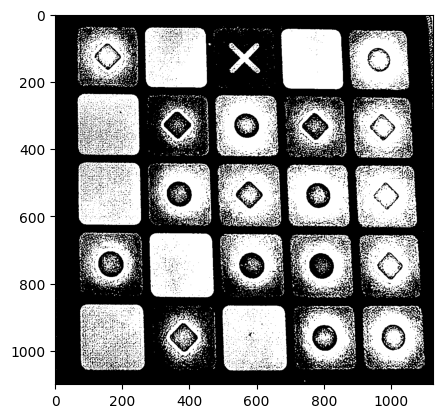

In [24]:
# contour detection section
img_h,img_w = gray_orig.shape
background_thresh = gray_orig[0][0]
ADD_THRESH = 90
total_thresh = background_thresh 
_,thresh_img = cv2.threshold(blur,total_thresh,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(thresh_img, cmap="gray", vmin=0, vmax=255)

contours, hier = cv2.findContours(thresh_img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
contours = [contour for contour,h in zip(contours,hier[0]) if h[3] == -1 and h[2] > -1]
top_25_contours = sorted(contours, key=lambda x : cv2.contourArea(x) if cv2.contourArea(x) < (img_h * img_w)/25 else 0,reverse=True)[:25]


# sort x and y later
coords_and_index = []
for i,contour in enumerate(top_25_contours):
    x, y, _, _ = cv2.boundingRect(contour)
    coords_and_index.append((i,x,y))


# sort by y
sorted_y = sorted(coords_and_index,key=lambda x:x[2])


# sort by x
for i in range(5):
    sorted_y[5 * i:5* (i + 1)] = sorted(sorted_y[5 * i:5* (i + 1)], key=lambda x:x[1])
top_25_sorted = [top_25_contours[i[0]] for i in sorted_y]



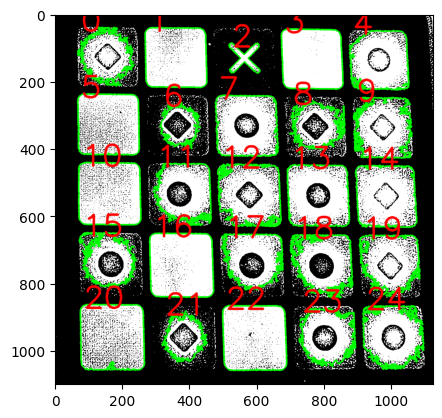

In [25]:
# hightlight contours and label each square to check correctness
print_img = cv2.cvtColor(thresh_img, cv2.COLOR_BGR2RGB)
cv2.drawContours(print_img, top_25_contours, -1, (0, 255, 0), 3)

font = cv2.FONT_HERSHEY_SIMPLEX

fontScale = 3
color = (255, 0, 0)
thickness = 5
for i, place in enumerate(sorted_y):  
    # print(i, place[1], place[2])
    cv2.putText(print_img, str(i), (place[1] + 10,place[2] + 10), font, 
                   fontScale, color, thickness, cv2.LINE_AA)

plt.imshow(print_img)

### 3. Color Detection --> Detect Color of each Square/Contour

In [26]:
# this stores the color of each respective square 
colors = []
hsv_cropped_img = cv2.cvtColor(cropped_color_card.copy(), cv2.COLOR_BGR2HSV)

lower_blue = np.array([60,100,50])
upper_blue = np.array([140,255,255])

lower_red = np.array([0,50,50])
upper_red = np.array([60,255,255])

lower_beige = np.array([0, 10, 120])
upper_beige = np.array([40, 80, 255])

lower_black = np.array([0, 0, 0])
upper_black = np.array([179, 255, 30])

for i, place in enumerate(sorted_y):
    color = np.mean(hsv_cropped_img[place[2]:place[2]+150, place[1]:place[1]+150], axis=(0, 1))
    # print(i, color)
    if all(color <= upper_beige) and all(color >= lower_beige):
        colors.append((i, "beige"))
    elif all(color <= upper_black) and all(color >= lower_black):
        colors.append((i, "black"))
    elif all(color <= upper_blue) and all(color >= lower_blue):
        colors.append((i, "blue"))
    elif all(color <= upper_red) and all(color >= lower_red):
        colors.append((i, "red"))
    else:
        colors.append((i, "black"))

# print(colors)
if len(colors) == 25:
    print('Found All Squares')
else:
    print("May not have found all squares")

Found All Squares


# Word Cards Processing

In [27]:
def read_words(filepath):
    img_board = cv2.imread(filepath)
    img_board = cv2.rotate(img_board, cv2.ROTATE_90_COUNTERCLOCKWISE)
    img_board_gray = cv2.cvtColor(img_board, cv2.COLOR_BGR2GRAY)
    img_h,img_w = img_board_gray.shape
    background_thresh = img_board_gray[0][0]
    ADD_THRESH = 90
    blur = cv2.GaussianBlur(img_board_gray,(5,5),0)
    total_thresh = background_thresh + ADD_THRESH
    _,thresh_img = cv2.threshold(blur,total_thresh,255,cv2.THRESH_BINARY)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
    opening = cv2.morphologyEx(thresh_img, cv2.MORPH_OPEN, kernel, iterations=1)
    contours, hier = cv2.findContours(opening,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    contours = [contour for contour,h in zip(contours,hier[0]) if h[3] == -1 and h[2] > -1]
    top_25_contours = sorted(contours, key=lambda x : cv2.contourArea(x) if cv2.contourArea(x) < (img_h * img_w)/25 else 0,reverse=True)[:25]

    # sort x and y later
    coords_and_index = []
    for i,contour in enumerate(top_25_contours):
        x, y, _, _ = cv2.boundingRect(contour)
        coords_and_index.append((i,x,y))
    sorted_y = sorted(coords_and_index,key=lambda x:x[2])
    for i in range(5):
        sorted_y[5 * i:5* (i + 1)] = sorted(sorted_y[5 * i:5* (i + 1)], key=lambda x:x[1])
    top_25_sorted = [top_25_contours[i[0]] for i in sorted_y]


    def flattener(image, pts, w, h):
        """Flattens an image of a card into a top-down 200x300 perspective.
        Returns the flattened, re-sized, grayed image.
        See www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/"""
        temp_rect = np.zeros((4,2), dtype = "float32")
        
        s = np.sum(pts, axis = 2)

        tl = pts[np.argmin(s)]
        br = pts[np.argmax(s)]

        diff = np.diff(pts, axis = -1)
        tr = pts[np.argmin(diff)]
        bl = pts[np.argmax(diff)]

        # Need to create an array listing points in order of
        # [top left, top right, bottom right, bottom left]
        # before doing the perspective transform

        if w <= 0.8*h: # If card is vertically oriented
            temp_rect[0] = tl
            temp_rect[1] = tr
            temp_rect[2] = br
            temp_rect[3] = bl

        if w >= 1.2*h: # If card is horizontally oriented
            temp_rect[0] = bl
            temp_rect[1] = tl
            temp_rect[2] = tr
            temp_rect[3] = br

        # If the card is 'diamond' oriented, a different algorithm
        # has to be used to identify which point is top left, top right
        # bottom left, and bottom right.
        
        if w > 0.8*h and w < 1.2*h: #If card is diamond oriented
            # If furthest left point is higher than furthest right point,
            # card is tilted to the left.
            if pts[1][0][1] <= pts[3][0][1]:
                # If card is titled to the left, approxPolyDP returns points
                # in this order: top right, top left, bottom left, bottom right
                temp_rect[0] = pts[1][0] # Top left
                temp_rect[1] = pts[0][0] # Top right
                temp_rect[2] = pts[3][0] # Bottom right
                temp_rect[3] = pts[2][0] # Bottom left

            # If furthest left point is lower than furthest right point,
            # card is tilted to the right
            if pts[1][0][1] > pts[3][0][1]:
                # If card is titled to the right, approxPolyDP returns points
                # in this order: top left, bottom left, bottom right, top right
                temp_rect[0] = pts[0][0] # Top left
                temp_rect[1] = pts[3][0] # Top right
                temp_rect[2] = pts[2][0] # Bottom right
                temp_rect[3] = pts[1][0] # Bottom left
                
            
        maxWidth = 200
        maxHeight = 300

        dst = np.array([[0,0],[maxWidth-1,0],[maxWidth-1,maxHeight-1],[0, maxHeight-1]], np.float32)
        M = cv2.getPerspectiveTransform(temp_rect,dst)
        warp = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
        warp = cv2.cvtColor(warp,cv2.COLOR_BGR2GRAY)

        return warp

    def find_words(top_25_sorted):
        words = []
        for cont in top_25_sorted:
            peri = cv2.arcLength(cont,True)
            approx = cv2.approxPolyDP(cont,0.01*peri,True)
            pts = np.float32(approx)
            corner_pts = pts

            x,y,w,h = cv2.boundingRect(cont)
            width, height = w, h

            average = np.sum(pts, axis=0)/len(pts)
            cent_x = int(average[0][0])
            cent_y = int(average[0][1])
            center = [cent_x, cent_y]

            warp = cv2.rotate(flattener(img_board, pts, w, h),cv2.ROTATE_90_COUNTERCLOCKWISE)
            cropped_img = warp[warp.shape[0]//2 + 20: warp.shape[0]-20, 20:warp.shape[1]-20]
            blur = cv2.GaussianBlur(cropped_img, (3,3), 0)
            contrast = cv2.convertScaleAbs(blur, alpha=1.3, beta=0)
            thresh = cv2.threshold(contrast, 0, 255, cv2.THRESH_BINARY_INV  + cv2.THRESH_OTSU)[1]
            words.append(pytesseract.image_to_string(thresh, lang='eng', config='--psm 6').strip().lower())
        return words
    words = find_words(top_25_sorted)
    if len(set(words)) == 25:
        print('success')
    else:
        print('fail, not all words may have been found')
    return(words)

words = read_words('assets/5x5.jpg')

success


# Clue Generator

In [28]:
red_words = []
blue_words = []
black_words = []
beige_words = []
for word, color in zip(words, colors):
    if color[1] == 'red':
        red_words.append(word)
    elif color[1] == 'blue':
        blue_words.append(word)
    elif color[1] == 'black':
        black_words.append(word)
    elif color[1] == 'beige':
        beige_words.append(word)

In [29]:
# Load Google's pre-trained Word2Vec model - most common ~44k words
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
model = KeyedVectors.load_word2vec_format(
    word2vec_sample, binary=False)

In [30]:
ps = PorterStemmer()

best_guess = ""
best_words = []
best_sim = 0

# Filter words that are not in the vocab of the model
def filter_words(words):
    filtered_words = []
    for word in words:
        try:
            _ = model[word]
            filtered_words.append(word)
        except KeyError:
            print(word, "not in vocab")
            continue
    return filtered_words

filtered_red = filter_words(red_words)
# filtered_blue = filter_words(blue_words)
filtered_black = filter_words(black_words)
# filtered_beige = filter_words(beige_words)

# Return powerset of words from start len to end len
def powerset(iterable,start,end):
    s = list(iterable)
    return list(chain.from_iterable(combinations(s, r) for r in range(start,end + 1)))

# Search from 1 or 2 to 4 word combinations
start = 1 if len(red_words) == 1 else 2
possible_answers = powerset(filtered_red, start, 4)

for possible_answer in possible_answers:
    guesses = model.most_similar(positive=list(possible_answer), negative=filtered_black)

    # Use stemming to filter out words that are from the same root word
    final_guess = []
    for guess in guesses:
        final_guess = guess
        valid_guess = True
        for word in possible_answer:
            if(ps.stem(word) == ps.stem(guess[0]) or word.lower() in guess[0].lower() or guess[0].lower() in word.lower()):
                valid_guess = False
                break
        if valid_guess:
            break

    if final_guess[1] > best_sim:
        print(guesses)
        best_guess = final_guess[0]
        best_words = possible_answer
        best_sim = final_guess[1]

print("Original answer words:", filtered_red)
print("Clue:", best_guess, len(best_words))
print("Words linked:", best_words)
print("Similarity score:", best_sim)

[('nuts', 0.39204660058021545), ('souls', 0.38413435220718384), ('fucken', 0.3808698356151581), ('lunatic', 0.376589834690094), ('egotist', 0.37541136145591736), ('genius', 0.3747096657752991), ('zealot', 0.37396854162216187), ('goodness', 0.37045928835868835), ('simpleton', 0.3695855736732483), ('realest', 0.3672119677066803)]
[('movie', 0.542242705821991), ('films', 0.5172964334487915), ('cinema', 0.5044494271278381), ('cinematic', 0.47767847776412964), ('screenplay', 0.4573911428451538), ('soulful', 0.4561014175415039), ('movies', 0.4338311553001404), ('documentary', 0.42586612701416016), ('protagonist', 0.42145857214927673), ('Film', 0.4209044873714447)]
[('soulful', 0.5907877087593079), ('guitar', 0.5643411874771118), ('saxophone', 0.5533952713012695), ('sax', 0.5498515367507935), ('pianist', 0.5420224666595459), ('violin', 0.5374598503112793), ('melody', 0.5338707566261292), ('melodies', 0.5162758827209473), ('clarinet', 0.5148530006408691), ('jazz', 0.5088408589363098)]
[('movie